## import needed libraries

In [26]:
#os libraries
import os 
import itertools 
from PIL import Image
# data handling libraries 
import cv2 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,classification_report 
#deep learning libraries 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam ,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras import regularizers
import warnings 
warnings.filterwarnings('ignore')


## Data Preprocessing

In [27]:
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data 

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [28]:
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing' 
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath) 
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt 

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


## Split data to Train , valid , test 

In [29]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

## create image data generator

In [30]:
batch_size=16
img_size = (224,224)
channels = 3 
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


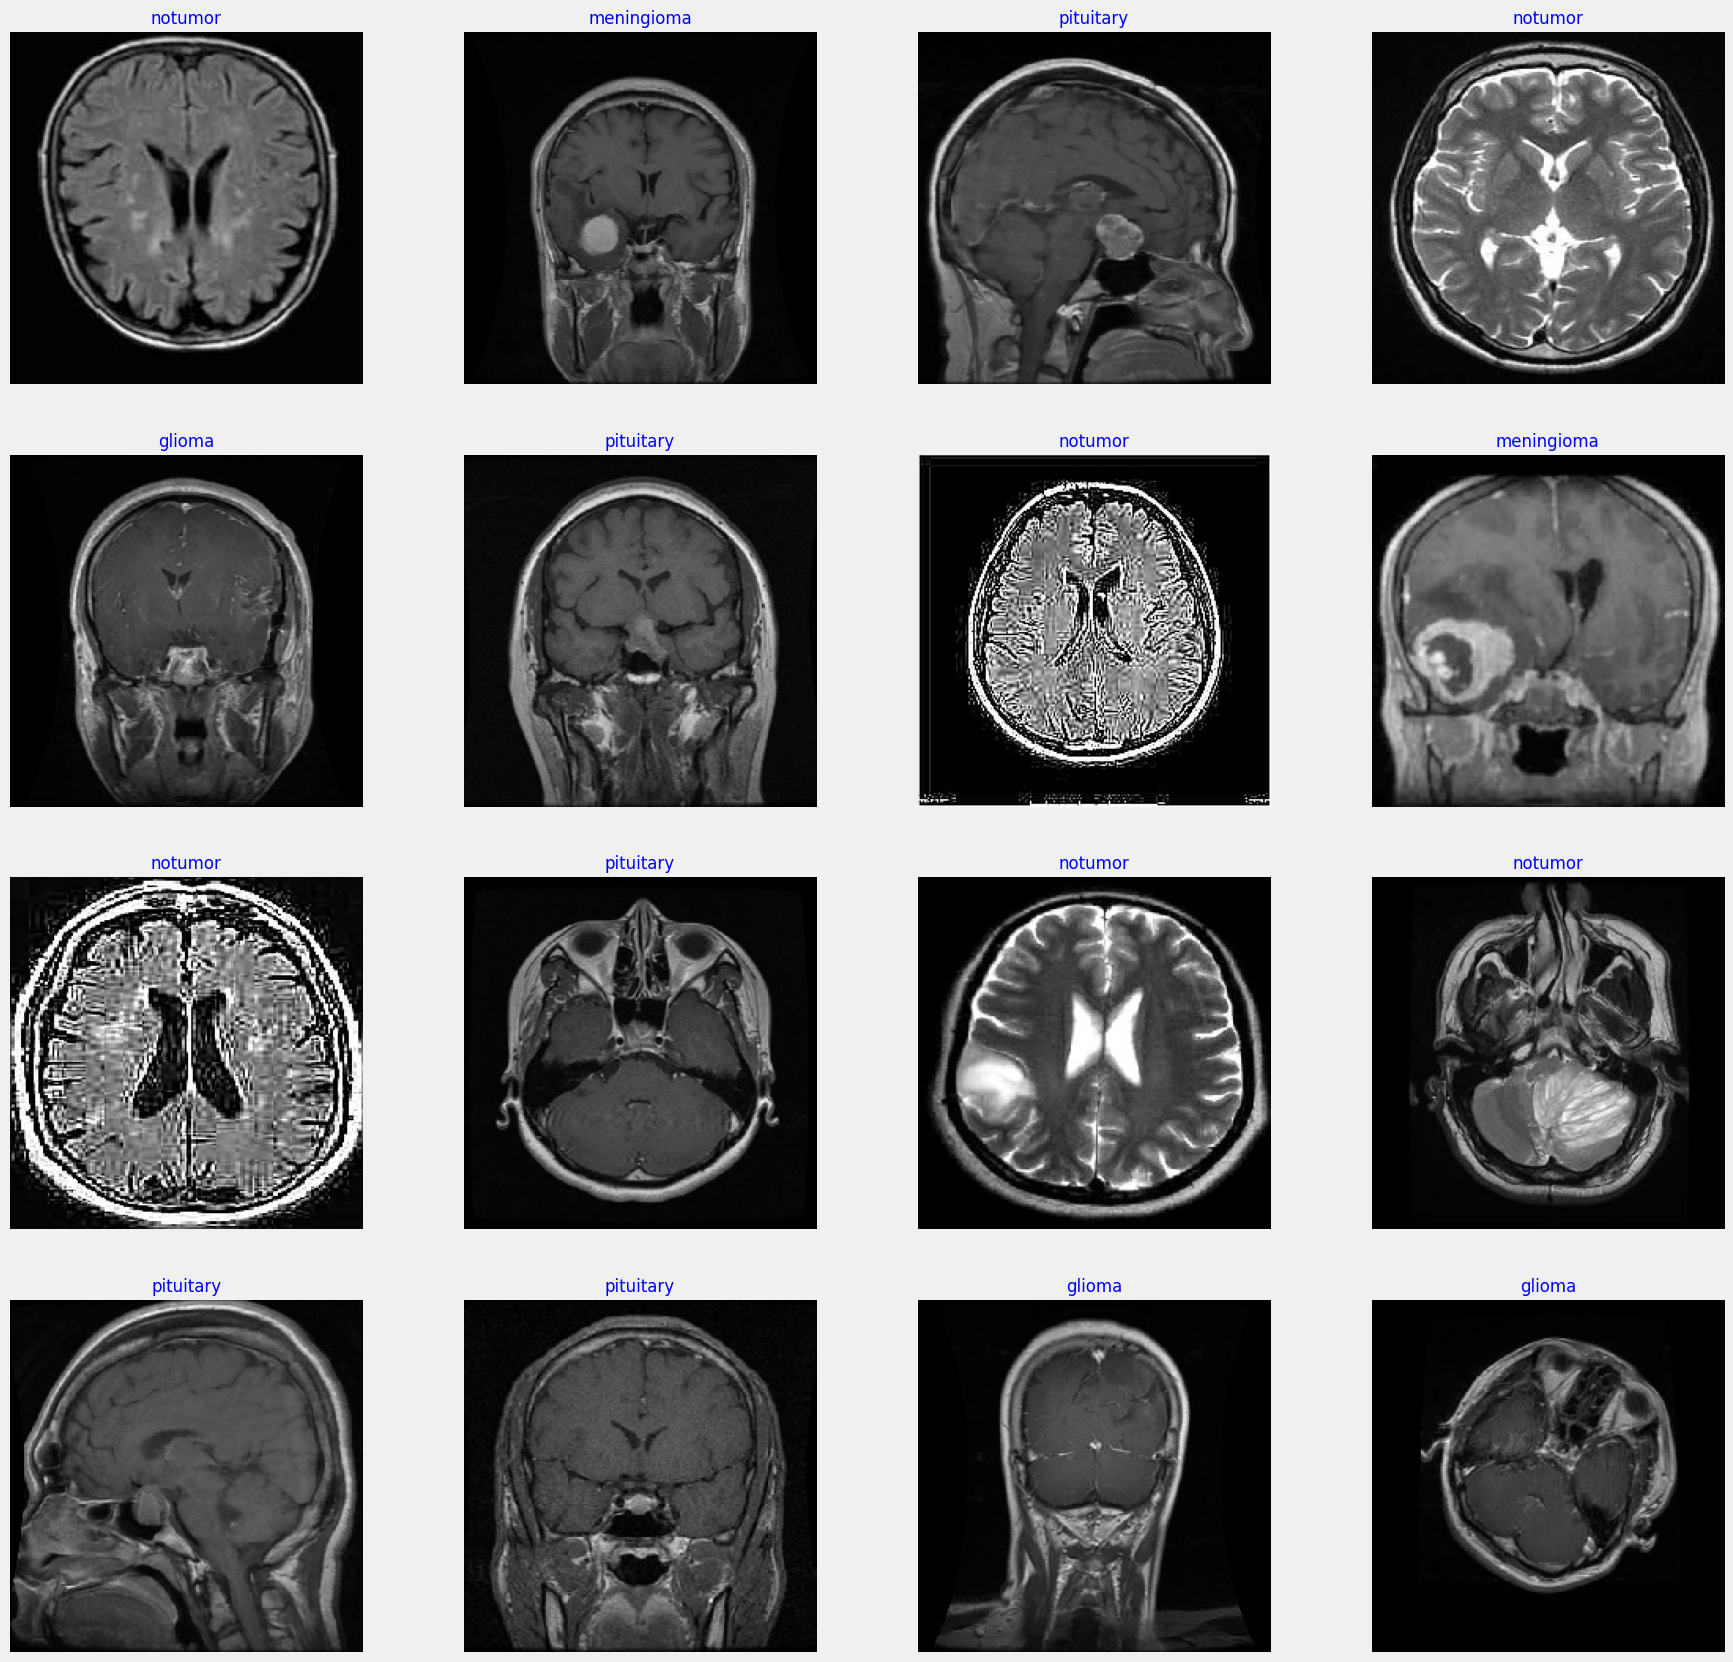

In [31]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show();

## model Structure

In [32]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = 'relu' ,input_shape=img_shape),
    Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    

    Dense(256, activation='relu',input_dim=30),
    Dense(64,activation = 'relu'),
    Dense(class_count, activation = 'softmax')
])
model.compile(Adamax(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [33]:
epochs = 10 

history = model.fit(x=train_gen,epochs= epochs, validation_data=valid_gen,shuffle= False)

Epoch 1/10
357/357 [==============================] - 41s 104ms/step - loss: 4.8484 - accuracy: 0.7029 - val_loss: 0.5754 - val_accuracy: 0.8107
Epoch 2/10
357/357 [==============================] - 37s 103ms/step - loss: 0.3492 - accuracy: 0.8787 - val_loss: 0.4273 - val_accuracy: 0.8473
Epoch 3/10
357/357 [==============================] - 37s 104ms/step - loss: 0.2344 - accuracy: 0.9196 - val_loss: 0.2811 - val_accuracy: 0.9130
Epoch 4/10
357/357 [==============================] - 37s 103ms/step - loss: 0.1596 - accuracy: 0.9449 - val_loss: 0.2349 - val_accuracy: 0.9282
Epoch 5/10
357/357 [==============================] - 37s 103ms/step - loss: 0.1085 - accuracy: 0.9636 - val_loss: 0.2257 - val_accuracy: 0.9282
Epoch 6/10
357/357 [==============================] - 37s 103ms/step - loss: 0.0781 - accuracy: 0.9744 - val_loss: 0.2172 - val_accuracy: 0.9328
Epoch 7/10
357/357 [==============================] - 37s 103ms/step - loss: 0.0417 - accuracy: 0.9883 - val_loss: 0.1659 - val_ac

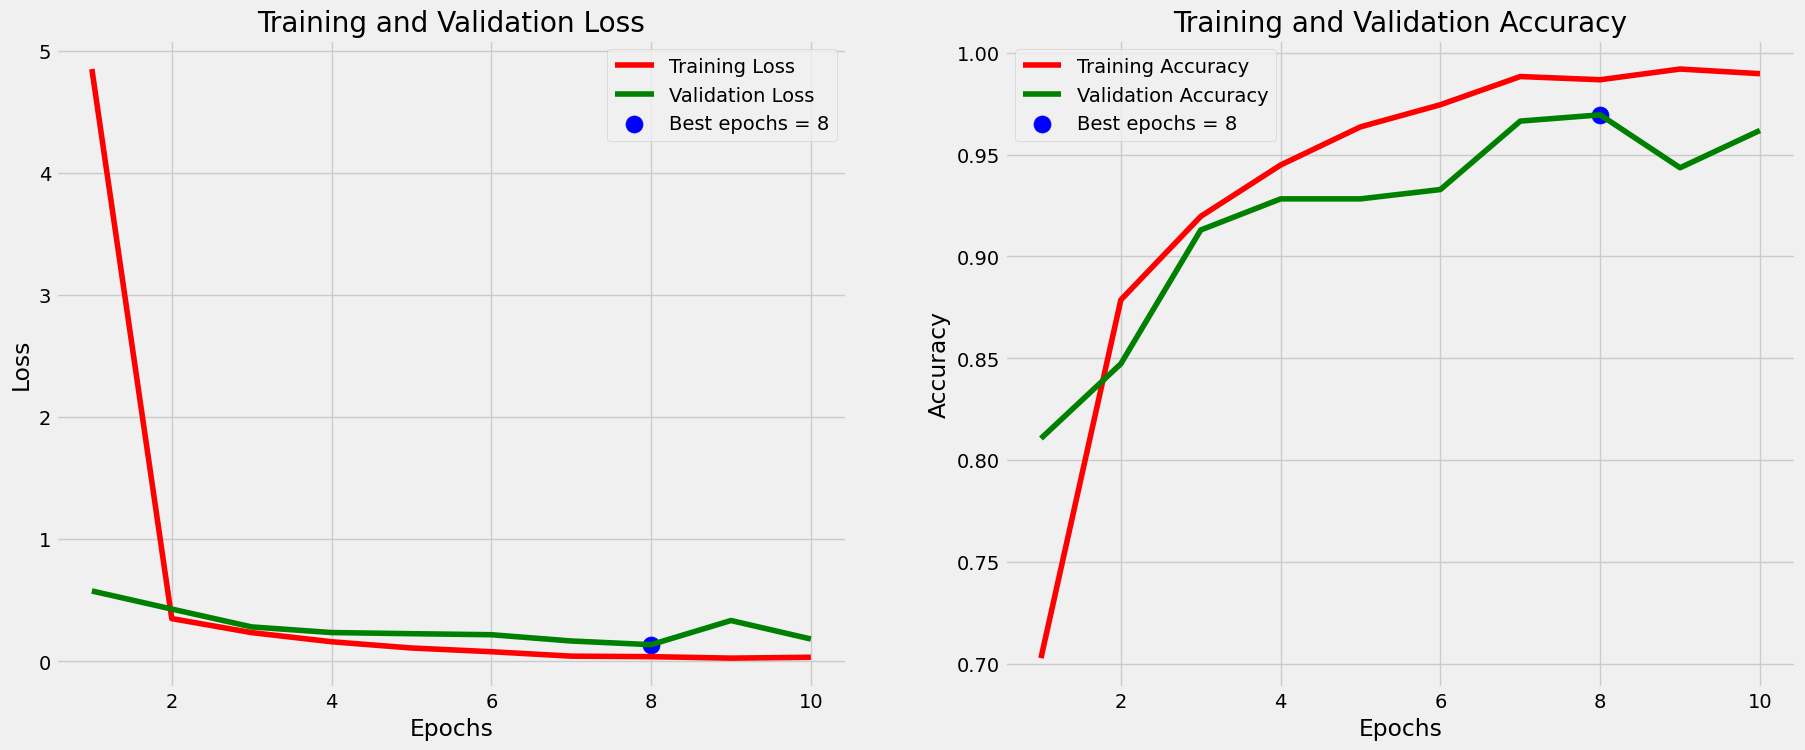

In [35]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();




## Evalute model

In [39]:
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)

41/41 [==============================] - 2s 38ms/step - loss: 0.1872 - accuracy: 0.9634


In [43]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)
y_pred

array([2, 0, 0, 3, 2, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 0,
       3, 3, 0, 2, 3, 1, 3, 2, 3, 3, 2, 2, 1, 3, 0, 1, 1, 3, 3, 2, 2, 0,
       1, 1, 1, 2, 2, 0, 3, 2, 2, 1, 3, 1, 2, 0, 3, 2, 1, 0, 2, 2, 2, 0,
       1, 2, 0, 2, 3, 0, 3, 0, 0, 3, 2, 2, 0, 1, 1, 2, 2, 2, 1, 3, 1, 3,
       1, 2, 0, 3, 1, 3, 1, 1, 1, 1, 2, 2, 3, 2, 2, 0, 1, 2, 3, 1, 2, 2,
       3, 1, 0, 3, 2, 0, 2, 1, 0, 1, 0, 2, 1, 2, 3, 2, 0, 3, 3, 2, 3, 1,
       3, 2, 1, 3, 0, 1, 1, 0, 2, 2, 3, 1, 3, 0, 1, 0, 0, 1, 3, 3, 1, 2,
       2, 3, 2, 2, 2, 3, 0, 3, 2, 3, 1, 1, 0, 0, 3, 3, 3, 3, 0, 3, 3, 2,
       3, 1, 0, 0, 0, 3, 3, 3, 1, 0, 3, 3, 2, 3, 0, 3, 1, 0, 2, 2, 3, 3,
       3, 3, 3, 2, 0, 2, 0, 3, 3, 2, 3, 3, 1, 1, 3, 2, 2, 3, 2, 2, 2, 1,
       3, 1, 2, 2, 0, 2, 3, 0, 1, 0, 0, 1, 0, 2, 0, 2, 1, 3, 2, 2, 0, 2,
       2, 3, 3, 1, 2, 1, 2, 2, 0, 2, 1, 1, 1, 1, 0, 3, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 2, 0, 0, 3, 3, 2, 3, 0, 2, 2, 2, 0, 0, 1, 1, 1, 2, 1, 0,
       0, 3, 1, 0, 2, 3, 0, 1, 2, 3, 0, 2, 1, 0, 0,

In [42]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm 

array([[138,  11,   0,   0],
       [  9, 132,   1,   1],
       [  0,   0, 200,   0],
       [  0,   2,   0, 162]])

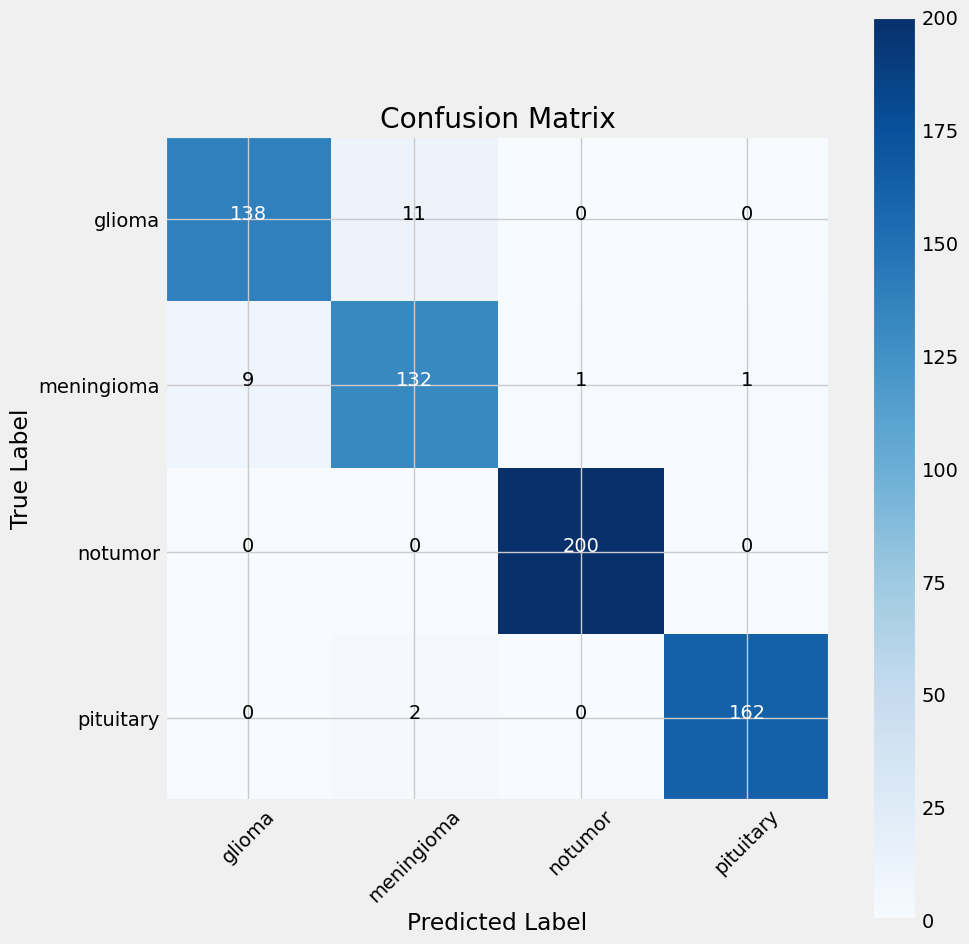

In [44]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [50]:
print(classification_report(test_gen.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      glioma       0.94      0.93      0.93       149
  meningioma       0.91      0.92      0.92       143
     notumor       1.00      1.00      1.00       200
   pituitary       0.99      0.99      0.99       164

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



## save model

In [51]:
model.save('Brain.h5')